Below is setup for Drake

In [1]:
try:
    import pydrake
    import underactuated
except ImportError:
    !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
    from jupyter_setup import setup_underactuated
    setup_underactuated()

# Setup matplotlib.
from IPython import get_ipython
if get_ipython() is not None: get_ipython().run_line_magic("matplotlib", "inline")

In [3]:
# python libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import sys 
import platform
import pydrake
from pydrake.solvers import branch_and_bound

# pydrake imports
from pydrake.all import (MultibodyPlant, Parser, DiagramBuilder, Simulator, Box, ne,
                         PlanarSceneGraphVisualizer, SceneGraph, TrajectorySource,
                         SnoptSolver, MultibodyPositionToGeometryPose, PiecewisePolynomial,
                         MathematicalProgram, JacobianWrtVariable, eq, LinearQuadraticRegulator,
                         Linearize, AddMultibodyPlantSceneGraph, VectorSystem, le, ge, OsqpSolver, PrismaticJoint,
                         Cylinder,Box,RigidTransform, CoulombFriction, IllustrationProperties)
# underactuated imports
from underactuated import FindResource

In [4]:
#clears file and downloads urdf to have it be updated
get_ipython().system(u"rm -rf /opt/hopper")
if platform.system() == "Darwin":
  get_ipython().system(u"if [ ! -d '/opt/hopper' ]; then git clone https://github.com/Olliebear/underactuated_final_project.git /opt/hopper; fi")
elif platform.linux_distribution() == ("Ubuntu", "18.04", "bionic"):
  get_ipython().system(u"if [ ! -d '/opt/hopper' ]; then git clone https://github.com/Olliebear/underactuated_final_project.git /opt/hopper; fi" )
else:
  assert False, "Unsupported platform"
sys.path.append("/opt/hopper")

AttributeError: module 'platform' has no attribute 'linux_distribution'

In [7]:

builder=DiagramBuilder()
hopper, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0)
Parser(hopper).AddModelFromFile('./Robot_URDF/hopper.urdf')

hopper.Finalize()
hopper=hopper.ToAutoDiffXd()

nq=hopper.num_positions()
print(nq)

nf=2

context=hopper.CreateDefaultContext()
context.SetTime(0)


6


In [8]:
def make_animation(x_trj,h_trj,vis_hopper,ground_on=False, xlim=[-4 , 4],ylim=[-.2 , 5] ):

  builder=DiagramBuilder()
  scene_graph = SceneGraph()
  builder.AddSystem(scene_graph)
  vis_hopper.RegisterAsSourceForSceneGraph(scene_graph)
  #print(x_trj)
  x_trj_new=x_trj.copy()
  for i,x in enumerate(x_trj[:,0]):
    x_trj_new[i,:]=[x_trj[i,0],x_trj[i,1],x_trj[i,2],x_trj[i,4],x_trj[i,3]-x_trj[i,2]]

  #print(x_trj.size())
  Parser(visual_hopper).AddModelFromFile('/opt/hopper/hopper.urdf')
  add_ground(visual_hopper,ground_on)
  visual_hopper.Finalize()
  #pretty much all of this was copied from compass gait problem in the homework
  time_breaks_opt = np.array([sum(h_trj[:t]) for t in range(len(h_trj)+1)])
  x_trj_poly = PiecewisePolynomial.FirstOrderHold(time_breaks_opt, x_trj_new.T)


  source = builder.AddSystem(TrajectorySource(x_trj_poly))
  pos_to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(vis_hopper))
  builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())

  builder.Connect(pos_to_pose.get_output_port(), scene_graph.get_source_pose_port(vis_hopper.get_source_id()))

  visualizer = builder.AddSystem(PlanarSceneGraphVisualizer(scene_graph, xlim=xlim, ylim=ylim, show=False))
  builder.Connect(scene_graph.get_pose_bundle_output_port(), visualizer.get_input_port(0))
  simulator = Simulator(builder.Build())

  # generate and display animation
  visualizer.start_recording()
  simulator.AdvanceTo(x_trj_poly.end_time())
  ani = visualizer.get_recording_as_animation()
  return ani

In [9]:
def manipulator_equations_air(vars):
  # split input vector in subvariables
    # configuration, velocity, acceleration, stance-foot force
    assert vars.size == 3 * nq + 2

    print(vars)
    split_at = [nq, 2 * nq, 3 * nq]
    q, qd, qdd, u = np.split(vars, split_at)

    r1,r2,m1,m2,I1,I2=[0.5,0.7,1,10,1,10]

    Fy=0
    Fx=0
    
    g=9.81
    c1=np.cos(q[2])
    c2=np.cos(q[3])
    s1=np.sin(q[2])
    s2=np.sin(q[3])

    z=q[4]+1
    W=z-r1
    uT=u[1]

    F_spring=get_spring_force(z,u[0])

    dth1=qd[2]
    dth2=qd[3]
    dz=qd[4]
    ddth1=qdd[2]
    ddth2=qdd[3]
    ddx=qdd[0]
    ddy=qdd[1]
    ddz=qdd[4]

    #got from https://github.com/RobotLocomotion/drake/blob/last_sha_with_original_matlab/drake/examples/PlanarMonopodHopper/HopperPlant.m

    a=r1*Fy*s1 - r1*Fx*c1 - uT;

    M=np.array([[-m1*W,0,(I1-m1*W*r1)*c1,0,0], 
                [0,m1*W,(I1-m1*W*r1)*s1,0,0], 
                [m2*W,0, (I1+m2*W*z)*c1, m2*W*r2*c2, m2*W*s1],
                [0,-m2*W,(I1+m2*W*z)*s1,m2*W*r2*s2,-m2*W*c1], 
                [0,0,I1*r2*np.cos(q[2]-q[3]),-I2*W,0]]) 

    eta=np.array([a*c1 - W*(Fx - F_spring*s1 - m1*r1*dth1**2*s1), 
                  a*s1 + W*(m1*r1*dth1**2*c1 + Fy - F_spring*c1 - m1*g), 
                  a*c1 + W*F_spring*s1 + m2*W*(z*dth1**2*s1 + r2*dth2**2*s2 -2*dz*dth1*c1),
                  a*s1 - W*(F_spring*c1 - m2*g) - m2*W*(2*dz*dth1*s1 + z*dth1**2*c1 + r2*dth2**2*c2), 
                  a*r2*np.cos(q[2]-q[3]) - W*(r2*F_spring*np.sin(q[3]-q[2]) + uT)])    

    return M.dot(qdd)-eta.T


In [ ]:
def manipulator_equations_ground(vars):
  # split input vector in subvariables
    # configuration, velocity, acceleration, stance-foot force
    assert vars.size == 3 * nq + 2
    split_at = [nq, 2 * nq, 3 * nq]
    q, qd, qdd, u = np.split(vars, split_at)

    r1,r2,m1,m2,I1,I2=[0.5,0.7,1,10,1,10]
    
    Fy=get_ground_spring(q[0],q[1],qd[1])
    cv=300 
    Fx=cv * qd[0]
    
    g=9.81
    c1=np.cos(q[2])
    c2=np.cos(q[3])
    s1=np.sin(q[2])
    s2=np.sin(q[3])

    z=q[4]+1
    W=z-r1
    uT=u[1]

    F_spring=get_spring_force(z,u[0])

    dth1=qd[2]
    dth2=qd[3]
    dz=qd[4]
    ddth1=qdd[2]
    ddth2=qdd[3]
    ddx=qdd[0]
    ddy=qdd[1]
    ddz=qdd[4]

    #got from https://github.com/RobotLocomotion/drake/blob/last_sha_with_original_matlab/drake/examples/PlanarMonopodHopper/HopperPlant.m

    a=r1*Fy*s1 - r1*Fx*c1 - uT;

    M=np.array([[-m1*W,0,(I1-m1*W*r1)*c1,0,0], 
                [0,m1*W,(I1-m1*W*r1)*s1,0,0], 
                [m2*W,0, (I1+m2*W*z)*c1, m2*W*r2*c2, m2*W*s1], 
                [0,-m2*W,(I1+m2*W*z)*s1,m2*W*r2*s2,-m2*W*c1], 
                [0,0,I1*r2*np.cos(q[2]-q[3]),-I2*W,0]]) 

    eta=np.array([a*c1 - W*(Fx - F_spring*s1 - m1*r1*dth1**2*s1), 
                  a*s1 + W*(m1*r1*dth1**2*c1 + Fy - F_spring*c1 - m1*g), 
                  a*c1 + W*F_spring*s1 + m2*W*(z*dth1**2*s1 + r2*dth2**2*s2 -2*dz*dth1*c1), 
                  a*s1 - W*(F_spring*c1 - m2*g) - m2*W*(2*dz*dth1*s1 + z*dth1**2*c1 + r2*dth2**2*c2),
                  a*r2*np.cos(q[2]-q[3]) - W*(r2*F_spring*np.sin(q[3]-q[2]) + uT)])    
    
    return M.dot(qdd)-eta

In [ ]:
def get_spring_force(z0,uX):
  #k=1000 #spring constant
  #kL=1 #relaxed length
  #if z0>0:
    #k=k*100
    #uX=0
  #return k*(-z0+uX)

  #this is if uX is stiffness variable
  #if z0>0: #if above 0, backwards force is stronger
    #uX=uX*100
  #return -uX*z0

  k=500 #found that 500 worked better thn 1000, easier to find solutions
  k0=1
  if (k0-z0+uX)>0:
    return k*(k0-z0+uX)
  else:
    return k*100*(k0-z0+uX) #contact occurs, make spring constant stiffer

In [ ]:
def get_ground_schedule(num_steps,num_hits,density=False): #creates predetermined ground contact schedule 
  schedule=np.zeros(num_steps)
  if density:
    schedule=None
  else:#first time running, no prescribed density
    total_num=num_hits*2+1 #starts in air, ends on ground, 
    steps_per_hit=int(num_steps/total_num)
    for i in range(total_num):
      if (i%2==1): #if odd, on the ground
        lower=int((i+2/5)*steps_per_hit)
        upper=int((i+3/5)*steps_per_hit)
        schedule[lower:upper]=np.ones(upper-lower)
  return schedule

In [ ]:
def get_ground_spring(x,y,yd):
  y_eq=y-get_ground_height(x)
  kg=10000
  #cv=100 #damping
  return -kg*y_eq #- cv*yd this didnt work because it caused the ground to exert negative force on the hopper as it tried to rise up out of the ground


In [ ]:
def get_ground_height(x):
  #use this to get the height at some position x. can change to have variable terrain
  #return x
  #print(x)
  #didnt work for anything other than 0
  '''
  if x>=0.3 and x<=0.8:
    return 0.5
  if x>0.8 and x<1.3:
    return 1
  if x>1.3 and x<1.8:
    return 1.5
  if x>1.8 and x<2.3:
    return 2 '''
  return 0
  #return step_func(x)

In [ ]:
def add_ground(hopper,x): #adds ground to scene for visual
  width=0.5
  height=0.5
  initial=0.8
  if x:
    ground=hopper.GetBodyByName("ground")
    transes=[np.array([initial,0,0]),np.array([initial+width,0,0]),np.array([initial+width*2,0,0]),np.array([initial+width*3,0,0])]
    boxes=[Box(width,1,2*height),Box(width,1,4*height),Box(width,1,6*height),Box(width,1,8*height)]
    color=IllustrationProperties()
    color.AddProperty("color","rgb","0,1,0")
    for i,box in enumerate(boxes):
      trans=RigidTransform(transes[i])
      hopper.RegisterVisualGeometry(ground,trans,box,'box'+str(i),np.array([0,0.5,0,1]))


In [ ]:
def get_h_trj(h1,h2,h3,grounded,N=np.Inf): #gets list of h values so that animation can be made
  h_trj=np.zeros(len(grounded))
  air1=True
  g_last=0
  for i,g in enumerate(grounded):
    if i%N==0 and i!=0:
      air1=not air1
    if g:
      h_trj[i]=h2

      if g_last==0:
        air1 = not air1
    else:
      if air1:
        h_trj[i]=h1 #first air step
      else:
        h_trj[i]=h3 #second air step

    g_last=g
  return h_trj

True
[0.00453347] [0.0423005] [0.00657269]
['drake::pydrake::(anonymous)::PyFunctionConstraint[3]: 0.000000 <= 0.000122 <= 0.000000', 'drake::pydrake::(anonymous)::PyFunctionConstraint[3]: 0.000000 <= -0.000106 <= 0.000000', 'drake::pydrake::(anonymous)::PyFunctionConstraint[3]: 0.000000 <= -0.000124 <= 0.000000', 'drake::pydrake::(anonymous)::PyFunctionConstraint[3]: 0.000000 <= -0.000143 <= 0.000000', 'drake::pydrake::(anonymous)::PyFunctionConstraint[3]: 0.000000 <= -0.000144 <= 0.000000', 'drake::pydrake::(anonymous)::PyFunctionConstraint[3]: 0.000000 <= -0.000147 <= 0.000000', 'drake::pydrake::(anonymous)::PyFunctionConstraint[3]: 0.000000 <= -0.000141 <= 0.000000', 'drake::pydrake::(anonymous)::PyFunctionConstraint[2]: 0.000000 <= 0.000114 <= 0.000000', 'drake::pydrake::(anonymous)::PyFunctionConstraint[3]: 0.000000 <= 0.000117 <= 0.000000', 'drake::pydrake::(anonymous)::PyFunctionConstraint[3]: 0.000000 <= -0.000156 <= 0.000000', 'drake::pydrake::(anonymous)::PyFunctionConstrain

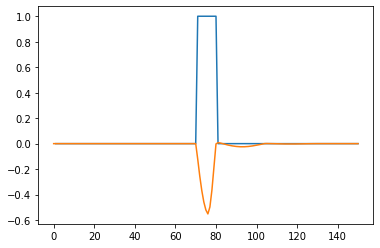

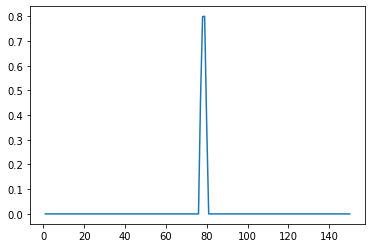

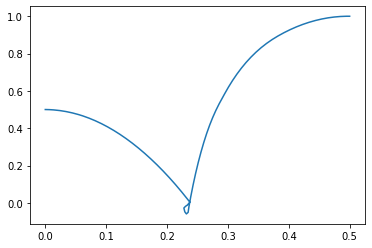

In [ ]:
#This program works to get the hopper to jump up steps at a steady rate

prog=MathematicalProgram()
N_step=150

step_length=0.5
step_height=0.5

y_i = 0.5 #initial height

q_initial=[0,y_i,0,0,0]
#qd_initial=[0,0,0,0,0]

q_final=[step_length,y_i+step_height,0,0,0]

h_max_air=.05
h_min_air=.001

h_max_g=.05
h_min_g=.001

#decision variables
h_air=prog.NewContinuousVariables(1,'h_air') #time step air
h_g=prog.NewContinuousVariables(1,'h_g') #time step ground
h_air_2=prog.NewContinuousVariables(1,'h_air_2')
q=prog.NewContinuousVariables(N_step+1,5,'q')
qd=prog.NewContinuousVariables(N_step+1,5,'qd')
qdd=prog.NewContinuousVariables(N_step,5,'qdd')
uZ=prog.NewContinuousVariables(N_step,1,'uZ') 
uT=prog.NewContinuousVariables(N_step,1,'uT')

#make grounded variable pre-scheduled 
number_of_contacts=1
grounded_step=get_ground_schedule(N_step,number_of_contacts)
M=100

#sets initial values for x, y, and z. thetas are allowed to move freely
prog.AddLinearConstraint(q[0,0]==q_initial[0])
prog.AddLinearConstraint(q[0,1]==q_initial[1])
prog.AddLinearConstraint(q[0,4]==q_initial[4])

#ensures final values are same as initial values for position and velocty, with final x and y shifted by step_height and step_width
prog.AddLinearConstraint(q[N_step,0]==q_final[0])
prog.AddLinearConstraint(q[N_step,1]==q_final[1])
prog.AddLinearConstraint(q[N_step,4]==q_final[4])
prog.AddLinearConstraint(q[N_step,2]==q[0,2])
prog.AddLinearConstraint(q[N_step,3]==q[0,3])
prog.AddLinearConstraint(eq(qd[N_step],qd[0])) 

prog.AddLinearConstraint(qd[0,1]>=0) #helps push solver in correct direction to get it to solve

#actuator constraints
prog.AddBoundingBoxConstraint([0]*N_step,[0.8]*N_step,uZ)
prog.AddBoundingBoxConstraint([-10]*N_step,[10]*N_step,uT)

#time step constraints
prog.AddBoundingBoxConstraint(h_min_air,h_max_air,h_air)
prog.AddBoundingBoxConstraint(h_min_air,h_max_air,h_air_2)
prog.AddBoundingBoxConstraint(h_min_g,h_max_g,h_g)

for t in range(N_step):
  prog.AddBoundingBoxConstraint(-1*np.ones(1),0.1*np.ones(1),q[t+1,4]) #fails with -0.8 as lower bound, even though it never reaches -0.8

  c=(q[t+1,4]+0.5)**2 >= 0.00001
  #print(c)
  prog.AddConstraint(c) #not equal to -0.5

  if grounded_step[t]: #grounded dynamics
    prog.AddLinearConstraint(q[t+1,1]<=0) #constrains toe to be on the ground during scheduled grounded times

    prog.AddConstraint(eq(q[t+1] , q[t] + h_g * qd[t+1]))
    prog.AddConstraint(eq(qd[t+1] , qd[t] + h_g * qdd[t]))

    var=np.concatenate((q[t+1],qd[t+1],qdd[t],uZ[t],uT[t]))
    prog.AddConstraint(manipulator_equations_ground, lb=[0]*nq, ub=[0]*nq, vars=var) #dynamics constraint

    prog.AddCost(h_g[0]*uT[t].dot(uT[t]))
    prog.AddCost(h_g[0]*uZ[t].dot(uZ[t]))

  else: #air dynamics
    prog.AddLinearConstraint(q[t+1,1]>=0) #toe is above ground while in the air
    if t>N_step/2: #selects which time step to use
      #print("ooh")
      h=h_air_2
    else:
      h=h_air
    prog.AddLinearConstraint(eq(uZ[t],0)) #if in air, no spring pre loading. Helps solver find solutions too
    prog.AddConstraint(eq(q[t+1] , q[t] + h * qd[t+1]))
    prog.AddConstraint(eq(qd[t+1] , qd[t] + h * qdd[t]))
    
    var=np.concatenate((q[t+1],qd[t+1],qdd[t],uZ[t],uT[t],))
    prog.AddConstraint(manipulator_equations_air, lb=[0]*nq, ub=[0]*nq, vars=var) #dynamics constraint
    
    prog.AddCost(h[0]*uT[t].dot(uT[t]))
    #prog.AddCost(h[0]*uZ[t].dot(uZ[t])) #not needed because uZ[t] is 0


solver=SnoptSolver()
result=solver.Solve(prog)

print(result.is_success())

q_star_step=result.GetSolution(q)
qd_star_step=result.GetSolution(qd)
qdd_star_step=result.GetSolution(qdd)
h1_step=result.GetSolution(h_air)
h2_step=result.GetSolution(h_g)
h3_step=result.GetSolution(h_air_2)
print(h1_step,h2_step,h3_step)
steps=np.linspace(0,N_step,N_step+1)
uZ_star_step=result.GetSolution(uZ)
uT_star_step=result.GetSolution(uT)
print(GetInfeasibleConstraints(prog,result))

plt.figure()
plt.plot(steps[1:],grounded_step)
plt.plot(steps,q_star_step[:,4])

plt.figure()
plt.plot(steps[1:],uZ_star_step)

plt.figure()
plt.plot(q_star_step[:,0],q_star_step[:,1])

In [ ]:
#print(qd_star[:,0])
#print(min(q_star_step[:,4]))
h_trj=get_h_trj(h1_step,h2_step,h3_step,grounded_step)
visual_hopper =MultibodyPlant(time_step=0)
a=make_animation(q_star_step,h_trj,visual_hopper,False)
HTML(a.to_jshtml())
#plt.figure()
#plt.plot(steps,q_star_step[:,2])
#plt.plot(steps,q_star_step[:,3])
#plt.plot(steps,q_star_step[:,4])

In [ ]:
def get_mult_steps(q_step,step_l,step_h,num_steps):
  N=len(q_step[:,0])-1
  q=np.zeros((num_steps*N+1,5))
  #print(q_step)
  add_array=np.zeros((N+1,5))
  add_array[:,0]=step_l*np.ones(N+1)
  add_array[:,1]=step_h*np.ones(N+1)
  #print(add_array)
  for a in range(num_steps):
    if a==num_steps-1:
      q[a*N:(a+1)*N+1]=q_step + a*add_array
    else:
      q[a*N:(a+1)*N]=q_step[0:N] + a*add_array[0:N]
  #print(q)
  return q

def get_mult_ground(grounded,num_steps):
  l=len(grounded)
  g=np.zeros(num_steps*l)

  for a in range(num_steps):
    g[a*l:(a+1)*l]=grounded
  return g

In [ ]:
#Link multiple jumps together to climb stairs
num=5
g=get_mult_ground(grounded_step,num)
q_many=get_mult_steps(q_star_step,step_length,step_height,num)
h_trj=get_h_trj(h1_step,h2_step,h3_step,g,N_step)
#print(h_trj)
visual_hopper =MultibodyPlant(time_step=0)
a=make_animation(q_many,h_trj,visual_hopper,True,xlim=[-2,4])
HTML(a.to_jshtml())
#print(qdd_star_step[:,1])

True
[0.00225611] [0.0290239] [0.01196165]


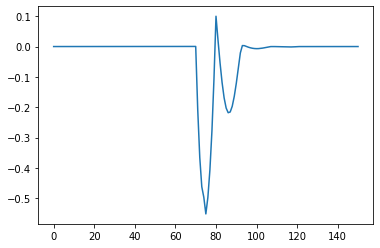

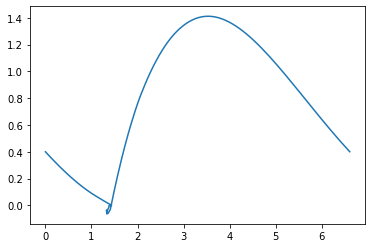

In [ ]:
#try for long, fast bounces

prog=MathematicalProgram()
N=150

y_i=0.5
q_initial=[0,0.75,0,0,0]
#qd_initial=[0,0,0,0,0]
#qd_final=qd_start_1

h_max_air=.1
h_min_air=.001

h_max_g=.1
h_min_g=.001

h_air=prog.NewContinuousVariables(1,'h_air') #time step air
h_g=prog.NewContinuousVariables(1,'h_g') #time step ground
h_air_2=prog.NewContinuousVariables(1,'h_air_2')
q=prog.NewContinuousVariables(N+1,5,'q')
qd=prog.NewContinuousVariables(N+1,5,'qd')
qdd=prog.NewContinuousVariables(N,5,'qdd')
uZ=prog.NewContinuousVariables(N,1,'uZ') #now make it force not length
uT=prog.NewContinuousVariables(N,1,'uT')

#make grounded variable pre-scheduled 
#make grounded variable pre-scheduled 
number_of_contacts=1
grounded=get_ground_schedule(N,number_of_contacts)
M=100
#Mf=10000

#prog.SetInitialGuess(q,q_star_2)
#prog.SetInitialGuess(h_air,h1_2)
#prog.SetInitialGuess(h_g,h2_2)
#prog.SetInitialGuess(h_air_2,h3_2)


prog.AddLinearConstraint(q[0,0]==0) #start at x=0

#prog.AddLinearConstraint(q[0,1]==y_i) #jumping height
prog.AddLinearConstraint(q[0,1]>=0.4)

#everything but x value stays the same
prog.AddLinearConstraint(q[0,1]==q[N,1])
prog.AddLinearConstraint(q[0,4]==q[N,4])
prog.AddLinearConstraint(q[N,2]==q[0,2])
prog.AddLinearConstraint(q[N,3]==q[0,3])

#prog.AddQuadraticCost(-1*q[N,0]**2) #try to maximize distance moved in one jump
prog.AddQuadraticCost(-5*qd[N,0]**2) #maximize x speed

#helps push solver in correct direction to get it to solve
prog.AddLinearConstraint(qd[0,0]>=0.1) #other wise solver sits at x=0, xd=0

prog.AddLinearConstraint(eq(qd[N],qd[0])) #velocities are equal to make it cyclic


prog.AddBoundingBoxConstraint([0]*N,[0.8]*N,uZ)
prog.AddBoundingBoxConstraint([-10]*N,[10]*N,uT)


prog.AddBoundingBoxConstraint(h_min_air,h_max_air,h_air)
prog.AddBoundingBoxConstraint(h_min_air,h_max_air,h_air_2)
prog.AddBoundingBoxConstraint(h_min_g,h_max_g,h_g)

k=1000 #change in spring_constraint too
for t in range(N):
  prog.AddBoundingBoxConstraint(-0.8*np.ones(1),0.1*np.ones(1),q[t+1,4])

  c=(q[t+1,4]+0.5)**2 >= 0.00001
  #print(c)
  prog.AddConstraint(c) #not equal to -0.5
  
  if grounded[t]: #grounded dynamics
    prog.AddLinearConstraint(q[t+1,1]<=0)

    prog.AddConstraint(eq(q[t+1] , q[t] + h_g * qd[t+1]))
    prog.AddConstraint(eq(qd[t+1] , qd[t] + h_g * qdd[t]))

    var=np.concatenate((q[t+1],qd[t+1],qdd[t],uZ[t],uT[t]))
    prog.AddConstraint(manipulator_equations_ground, lb=[0]*nq, ub=[0]*nq, vars=var) #dynamics constraint

    prog.AddCost(h_g[0]*uT[t].dot(uT[t]))
    prog.AddCost(h_g[0]*uZ[t].dot(uZ[t]))#

  else:
    prog.AddLinearConstraint(q[t+1,1]>=0)
    if t>N/2:
      h=h_air_2
    else:
      h=h_air
    #h=h_air
    prog.AddLinearConstraint(eq(uZ[t],0)) #if in air, no spring pre loading
    prog.AddConstraint(eq(q[t+1] , q[t] + h * qd[t+1]))
    prog.AddConstraint(eq(qd[t+1] , qd[t] + h * qdd[t]))
    
    var=np.concatenate((q[t+1],qd[t+1],qdd[t],uZ[t],uT[t],))
    prog.AddConstraint(manipulator_equations_air, lb=[0]*nq, ub=[0]*nq, vars=var) #dynamics constraint
    prog.AddCost(h[0]*uT[t].dot(uT[t]))#
    #prog.AddCost(h[0]*uZ[t].dot(uZ[t]))

solver=SnoptSolver()
result=solver.Solve(prog)
print(result.is_success())
q_star_2=result.GetSolution(q)
qd_star_2=result.GetSolution(qd)
steps=np.linspace(0,N,N+1)

h1_2=result.GetSolution(h_air)
h2_2=result.GetSolution(h_g)
h3_2=result.GetSolution(h_air_2)
print(h1_2,h2_2,h3_2)

plt.figure()
plt.plot(steps,q_star_2[:,4])

plt.figure()
plt.plot(q_star_2[:,0],q_star_2[:,1])

if result.is_success(): #use these to string together positions
  q_start_2=q_star_2[0]
  qd_start_2=qd_star_2[0]



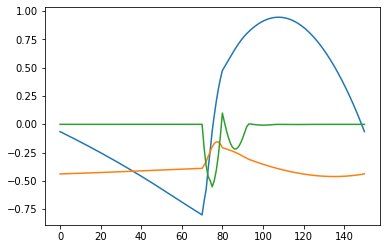

In [ ]:
h_trj=get_h_trj(h1_2,h2_2,h3_2,grounded)
#print(h_trj)
visual_hopper =MultibodyPlant(time_step=0)
a=make_animation(q_star_2,h_trj,visual_hopper,False,[-1,7],[-.2,4])
HTML(a.to_jshtml())
plt.figure()
plt.plot(steps,q_star_2[:,2])
plt.plot(steps,q_star_2[:,3])
plt.plot(steps,q_star_2[:,4])